In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_image = './contour_data/nline5.png'
green_mat = 'nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

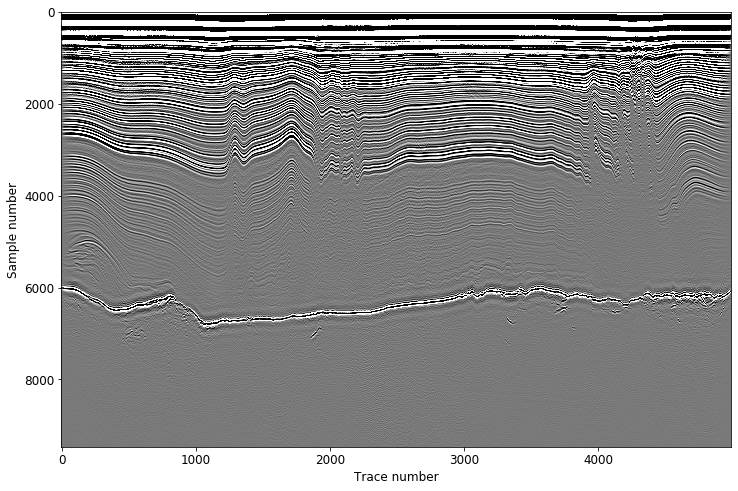

In [3]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [4]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [5]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [6]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



In [7]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

38
44400
298
30373


In [8]:
#isolate some contours
last_long_idx = long_contours_pos[-30:]
last_long_contours = [pos[idx] for idx in last_long_idx]

In [9]:
z = 1
argx1 = np.argmin(last_long_contours[z][:, 1])
argx2 = np.argmax(last_long_contours[z][:, 1])

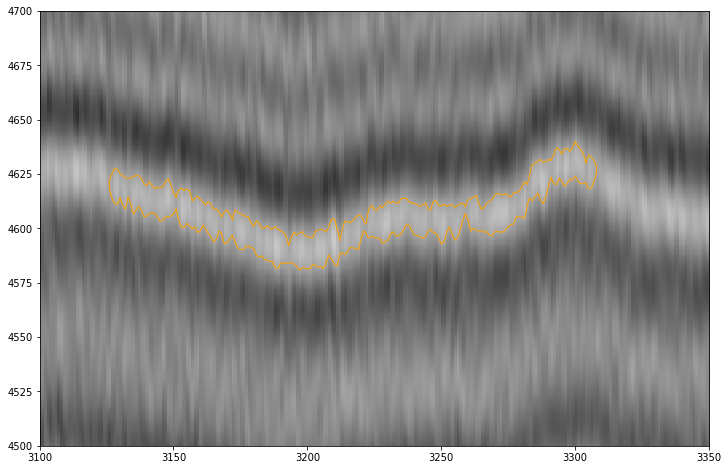

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

plt.xlim([3100, 3350])
plt.ylim([4500, 4700])
#plt.xlim([3100, 4100])
#plt.ylim([6300, 5900])

plt.show()

In [11]:
uniquex = (list(set([int(x) for x in last_long_contours[z][:, 1]])))

In [12]:
saved_points = []
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(last_long_contours[z][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points.append(wherex[1:3])
            #print(i, wherex[1:3])
        else:
            saved_points.append(wherex)
            #print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]

In [13]:
ridge_points = []

In [14]:
for i, point in enumerate(saved_points):
    if(len(point == 2)):
        idx1 = point[0]
        idx2 = point[1]
    elif(len(point > 2)):
        idx1 = point[1]
        idx2 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(last_long_contours[z][idx1, 0])
    y2 = int(last_long_contours[z][idx2, 0])
    
    if len(data[y2:y1, x]) == 0:
        ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
    else:
        ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        
ridge_points = [elem[0] for elem in ridge_points]

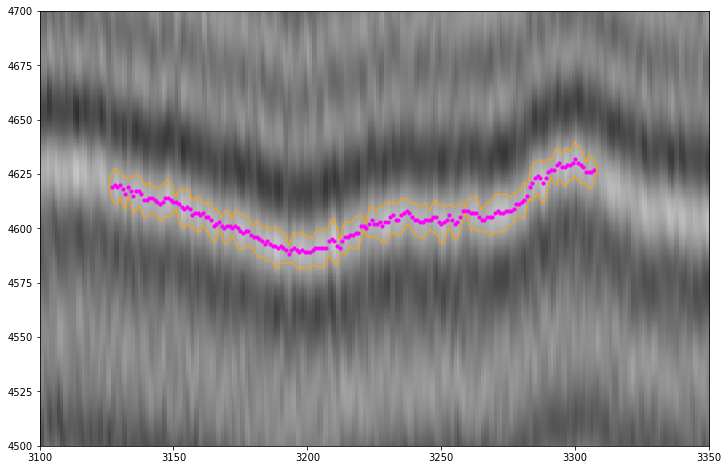

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

for i, x in enumerate(uniquex):
    y = ridge_points[i]
    ax.scatter(x, y, color='magenta', marker='o', s=10)

plt.xlim([3100, 3350])
plt.ylim([4500, 4700])
#plt.xlim([3100, 4100])
#plt.ylim([6300, 5900])

plt.show()

### What about the troughs? We will need them to keep track of the entire wavelet (trough-peak-trough).

We could:
- take the derivative of the image and see where we see zeros
- we could use the original image and then see where the first place is (above and below) that we see a changing in sign (+ --> - for positive contours, - --> + for negative contours)

In [17]:
def find_troughs(uniquex, ridge_points, data):
    maxrows, maxcols = np.shape(data)
    
    top, bottom = [], []
    temptop_idx, tempbottom_idx = [], []
    temptop_points, tempbottom_points = [], []

    for i, point in enumerate(uniquex):
        row = ridge_points[i]
        col = point

        #if the point holds a positive value, then we want to
        #find the troughs on either side of it
        if data[row, col] > 0:
            #look for top contour
            for j in range(row, maxrows):
                #enter the trough
                if (data[j, col] <= 0):
                    #print(j)
                    temptop_idx.append(j)
                    temptop_points.append(data[j, col])

                    #enterting this if statement would signify leaving the trough
                    if data[j+1, col] > 0:
                        #find the minimum in that column of the trough
                        trough_min = np.argmin(temptop_points)
                        top.append(temptop_idx[trough_min])

                        #reset these to empty for the next column
                        temptop_idx, temptop_points = [], []
                        break

            #look for bottom contour
            for k in range(0, row):
                #enter the trough
                if (data[row-k, col] <= 0):
                    tempbottom_idx.append(row-k)
                    tempbottom_points.append(data[row-k, col])

                    #enterting this if statement would signify leaving the trough
                    if data[row-k-1, col] > 0:
                        #find the minimum in that column of the trough
                        trough_bottom_min = np.argmin(tempbottom_points)
                        bottom.append(tempbottom_idx[trough_bottom_min])

                        #reset these to empty for the next column
                        tempbottom_idx, tempbottom_points = [], []
                        break


        #if the point holds a negative value, then we want to
        #find the peaks on either side of it
        else:
            pass

    return top, bottom

In [18]:
top, bottom = find_troughs(uniquex, ridge_points, data)

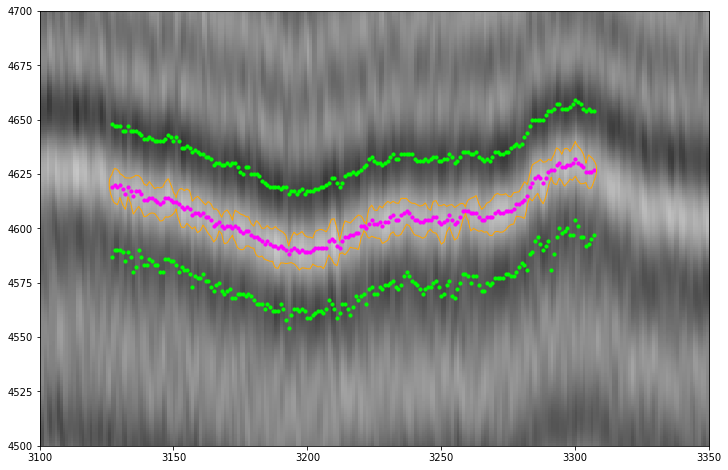

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

#plot contour
plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

#plot ridge and troughs
for i, x in enumerate(uniquex):
    y = ridge_points[i]
    t = top[i]
    b = bottom[i]
    ax.scatter(x, y, color='magenta', marker='o', s=10)
    ax.scatter(x, t, color='lime', marker='o', s=10)
    ax.scatter(x, b, color='lime', marker='o', s=10)

plt.xlim([3100, 3350])
plt.ylim([4500, 4700])
#plt.xlim([3400, 4000])
#plt.ylim([6250, 5950])

#plt.savefig('actual_contours3.pdf', format='pdf', bbox_inches='tight')

plt.show()

Power for picked wavelet is:

    np.mean(np.sum(bottom**2 + ridge**2 + top**2))

In [28]:
power = []

pick_power = np.mean(np.sum(np.array(top)**2 + np.array(ridge_points)**2 + np.array(bottom)**2))
power.append(pick_power)

In [30]:
print(power)

[59816536603.0]
